In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install flair
!pip install sentencepiece

     |████████████████████████████████| 286kB 3.0MB/s 
     |████████████████████████████████| 19.7MB 1.4MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 2.3MB 37.4MB/s 
     |████████████████████████████████| 983kB 34.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 28.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 798kB 28.0MB/s 
     |████████████████████████████████| 901kB 27.8MB/s 
     |████████████████████████████████| 3.3MB 26.1MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9693 sha256=6713986770e6f286f9cd6962b3b9970a5fb6fabd5f6a5420a61824522db1fedc
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Created wheel for langdetect: file

In [ ]:
import os
import math
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow_datasets as tfds
import tensorflow as tf

from flair.data import Sentence
from flair.embeddings import BertEmbeddings, DocumentPoolEmbeddings

In [ ]:
torch.cuda.current_device(), torch.cuda.get_device_name(device=None)

## Params

In [ ]:
MAX_SENT_N = 30

MAX_WORD_N = 150

MAX_WORD_SENT_N = 300

BATCHSIZE = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

## Tensorflow Dataset to numpy Dataset

In [ ]:
from segtok.segmenter import split_single
def split_in_sentences(text):
    return split_single(text)

In [ ]:

reddit300k = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/reddit300k_clean.csv"
redd = pd.read_csv(reddit300k, thousands  = ',',encoding='latin-1')
redd.drop('subreddit', inplace=True, axis=1)
redd.head()

,content,summary
0,"very late to the party, but this is a good one...",gramps lost his teeth at the beach and I found...
1,"Almost two weeks ago now, I lost my job, which...","Lost my job, friend now coming by twice a day ..."
2,I have a friend who has a bad habit of eating ...,Stealing makes you shop better
3,There was once an average looking girl that I ...,Playfully tease me \n edit- words
4,these stories are a dime a dozen. currently I'...,COMCAST CAN SUCK A DICK


In [ ]:

def split_df(df):
  if len(df) % 2 != 0:  # Handling `df` with `odd` number of rows
    df = df.iloc[:-1, :]
  df1, df2 =  np.array_split(df, 2)
  return df1, df2

# Creation of Dataset and Dataloader
# Defining the train size. So 60% of the data will be used for training and the rest will be used for validation and test sets. 
train_size = 0.6
train_tfds=redd.sample(frac=train_size,random_state = 42)
val_tfds=redd.drop(train_tfds.index).reset_index(drop=True)
val_tfds, test_tfds = split_df(redd)
train_tfds = train_tfds.reset_index(drop=True)

print("FULL Dataset: {}".format(redd.shape))
print("TRAIN Dataset: {}".format(train_tfds.shape))
print("VALIDATION Dataset: {}".format(val_tfds.shape))
print("TEST Dataset: {}".format(test_tfds.shape))

FULL Dataset: (164322, 2)
TRAIN Dataset: (98593, 2)
VALIDATION Dataset: (82161, 2)
TEST Dataset: (82161, 2)


In [ ]:
def normalize_text(text):
    """Lowercase and remove quotes from a TensorFlow string."""
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text,"'(.*)'", r"\1")
    return text


def map_func(features):
    content_text = normalize_text(features["content"])
    summary_text = normalize_text(features['summary'])
    
    return content_text.numpy().decode('UTF-8'), summary_text.numpy().decode('UTF-8')

In [ ]:
def tfds_to_numpy(ds):
    new_ds = pd.DataFrame(columns=["content", "summary"])
    for i, item in enumerate(ds):
        content, higlights = map_func(item)
        new_ds = new_ds.append({"contents": content, "summary": higlights}, ignore_index =True)
    return new_ds



In [ ]:
def save_to_csv(ds, name):
    ds.to_csv(str("data/" + name + ".tsv"), sep="\t", index=False)
    
def load_csv(name):
    return pd.read_csv(str("data/" + name + ".tsv"), sep="\t")

def create_new_csv():

    test_tfds.to_csv (r'/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/test_tfds.tsv', header=True, index = False)
    val_tfds.to_csv (r'/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/val_tfds.tsv', header=True, index = False)
    train_tfds.to_csv (r'/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/train_tfds.tsv', header=True, index = False)

    return 

def load_data():
    test_tfds ='/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/test_tfds.tsv'
    val_tfds ='/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/val_tfds.tsv'
    train_tfds ='/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/train_tfds.tsv'
    train_df = pd.read_csv(train_tfds, thousands  = ',',encoding='latin-1')
    test_df = pd.read_csv(test_tfds, thousands  = ',',encoding='latin-1')
    val_df = pd.read_csv(val_tfds, thousands  = ',',encoding='latin-1')
    return train_df, val_df, test_df


In [ ]:
create_new_csv()


In [ ]:
train_df, val_df, test_df = load_data()

## Sentence Piece
- https://github.com/google/sentencepiece
- use a Vocab size like Albert and BERT (30000) 

In [ ]:
import sentencepiece as spm

# train Sentence Piece with train.tsv
spm_model_name = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/spm_train"
spm_train_file_name = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/train_tfds.tsv"

if not os.path.exists(spm_model_name):
    spm.SentencePieceTrainer.Train(
            '--input=' + os.path.join(spm_train_file_name) +
            ' --model_prefix='+ os.path.join(spm_model_name) +
            ' --vocab_size=30000')

In [ ]:
sp_model = spm.SentencePieceProcessor()
sp_model.Load("/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/spm_train.model")
vocab = {sp_model.IdToPiece(i): i for i in range(sp_model.GetPieceSize())}
vocab_list = list(vocab.keys())
print("vocab len:", len(vocab), "\nTop 15: vocabs:", vocab_list[:15])

vocab len: 30000 
Top 15: vocabs: ['<unk>', '<s>', '</s>', '.', ',', '▁I', '▁the', '▁to', '▁and', '▁a', 'n', '▁of', 's', "'", '▁\\']


In [ ]:
eos_token = sp_model.eos_id() 
bos_token = sp_model.bos_id()
def get_real_text_from_ids(tokens):
    text = ""
    for token in tokens:
        #print(token)
        word = vocab_list[token]
        text += word.replace("▁", " ")
    return text

def get_ids_from_vocab(text):
    ids = sp_model.encode_as_ids(text)
    return ids + [eos_token]

test = "hallo, i'm leaving. this is another sentences."
tokens = get_ids_from_vocab(test)
#print(tokens)
print(get_real_text_from_ids(tokens))

 hallo, i'm leaving. this is another sentences.</s>


## Analyse Dataset

In [ ]:

reddit100 = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/reddit100_clean.csv"
redd100 = pd.read_csv(reddit100, thousands  = ',',encoding='latin-1')
redd100.drop('subreddit', inplace=True, axis=1)
redd100.head()

,content,summary
0,"No worries, same thing happened to me with my ...","Was a gentleman, first time BDSM, first time a..."
1,"Like some people have said here already, math ...","Physicists started using math as play blocks, ..."
2,right the opposite: whenever a used game is re...,good for companies but extremly bad for gamers...
3,"We had a regular wooden swing set, also not se...",make sure you have open space behind and in fr...
4,"I\'m kind of torn on this article, and the pub...",I entirely agree with the mother that mental h...


In [ ]:
# Creation of Dataset and Dataloader
# Defining the train size. So 60% of the data will be used for training and the rest will be used for validation and test sets. 
train_size = 0.6
train_df=redd100.sample(frac=train_size,random_state = 42)
val_df=redd100.drop(train_df.index).reset_index(drop=True)
val_df, test_df = split_df(val_df)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("FULL Dataset: {}".format(redd100.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))


FULL Dataset: (100, 2)
TRAIN Dataset: (60, 2)
VALIDATION Dataset: (20, 2)
TEST Dataset: (20, 2)


In [ ]:
n_content_sent = []
n_content_sent_words = []
n_summary_words = []

for i, (content, summary) in test_df.iterrows():
    split_sentences = split_in_sentences(content)
    n_content_sent.append(len(split_sentences))
    for sent in split_sentences:
        n_content_sent_words.append(len(sent))
    
    n_summary_words.append(len(get_ids_from_vocab(summary)))

In [ ]:
def print_mean(name, list_len):
    print("---", name, "---")
    print("mean: %d\tmedian: %d min/max: [%d/%d]"%(np.mean(list_len), np.median(list_len),\
                                                   np.min(list_len), np.max(list_len)))
    
print_mean("content sentence",n_content_sent)
print_mean("content sentence words",n_content_sent_words)
print_mean("higlights words", n_summary_words)

--- content sentence ---
mean: 8	median: 8 min/max: [1/24]
--- content sentence words ---
mean: 112	median: 99 min/max: [7/476]
--- higlights words ---
mean: 47	median: 32 min/max: [14/151]


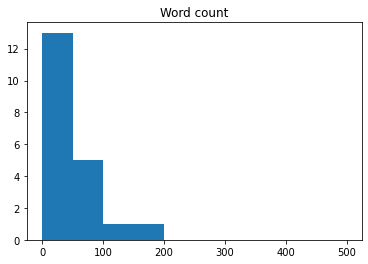

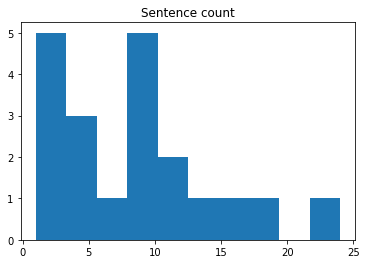

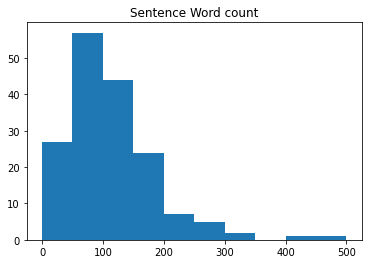

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Word count")
plt.hist(n_summary_words, range=(0,500))
plt.show()
plt.title("Sentence count")
plt.hist(n_content_sent)
plt.show()
plt.title("Sentence Word count")
plt.hist(n_content_sent_words, range=(0,500))
plt.show()

## Params Dataset

# Model 
1. Use the flair Embedding to get the Context Matrix and then user your one decoder
2. then try to get the vocab input for addidtional information and better results

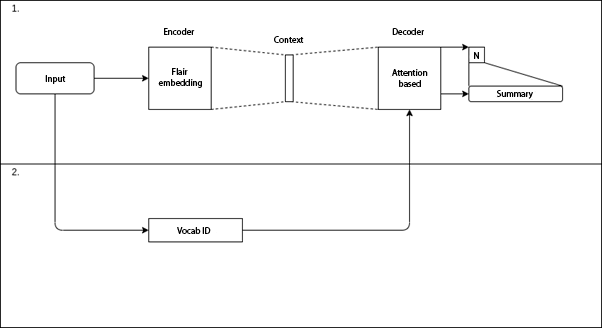
## Attention

$$ Attention(Q,K,V) = softmax(\frac{Q*K^{T}}{\sqrt{d_k}} ) * V  $$
 
Query $Q$ and Key $K$ represent the input, the dot product of them shows which key words the query word should focus on. The softmax gives them probabilistic values which define which words from the Value Matrix $V$ are relevant.
   

## Compute pytorch Dataset with flair
- for faster training, we will clean the data, compute the Albert-Base Embedding of all contents and save it to Files, so that we don't have to do it while training

In [ ]:
albert = BertEmbeddings(bert_model_or_path="albert-base-v2")

albert_embedding = DocumentPoolEmbeddings([albert])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  """Entry point for launching an IPython kernel.


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sent = Sentence("Berlin and Munich are nice cities .")
albert_embedding.embed(sent)

embedd_result = sent.get_embedding()
print(embedd_result.shape)
print(embedd_result)

torch.Size([3072])
tensor([-0.6863, -0.5820,  1.0685,  ...,  0.7118,  0.6721,  0.5402])


In [ ]:
test_df.content[19]

"Hi Reddit, \\n Please excuse any grammar or spelling errors as I have been drinking tonight. \\n I ask all of Reddit to please not let your friends drink and drive. I stopped my childhood friend who I met in Kindergarten (We are both 25 now) from driving home tonight. We had 4 people playing beer pong and we played 10 games. \\n I drink a lot more than him, I am not wasted but I also knew I shouldn't be driving. It took a lot of convincing and lying to get him just to stick around for 5 more minutes. \\n Sure enough he ended up puking and passed out very shortly after on the couch. \\n He is back in town to visit his parents and they literally live 2 minutes away. I have never seen a cop EVER between his house and the one I am living at now. \\n But I could of save some innocent live tonight or his for all I know. \\n So please Reddit, the DUI, the life, the car, the getting home so your parents don't worry, ITS NEVER WORTH THE FUCKING RISK. Stand up to them. It is always better to be

#### Error with pandas writing np.array to csv
[-2.46214211e-01 -3.16317886e-01  8.51760387e-01 ... -3.47209573e-02
   4.56400543e-01 -9.96351242e-04]
  

- We need to disable the numpy option to cut (summarize) the array. We have a (30,3072) array so we just set the threshold higher than that.

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
def embed_sentences(sentences):
    arr_embedding = np.zeros((MAX_SENT_N, 3072))
    for i, sentence in enumerate(sentences):
        if len(sentence) > 0 and i < MAX_SENT_N:
            sent = Sentence(sentence[:MAX_WORD_SENT_N])

            albert_embedding.embed(sent)
            x = sent.get_embedding()
            x = x.to('cpu').detach().numpy()
            arr_embedding[i] = x
    
    return arr_embedding

embed_sentences(split_in_sentences(test_df.content[0]))[0]

array([-3.70830297e-02, -1.88600376e-01,  7.15847731e-01, -4.31347460e-01,
        4.47101206e-01, -7.40904436e-02, -1.07672083e+00, -4.07272339e-01,
        4.67981339e-01,  5.66267729e-01,  2.87130803e-01, -1.21313632e-01,
        2.28742421e-01,  3.36077303e-01, -1.12488791e-02, -3.26888293e-01,
       -8.36362898e-01, -4.06932682e-01,  6.71004832e-01, -3.69201675e-02,
       -3.21433060e-02, -1.66897774e-01, -3.81361216e-01,  2.30525240e-01,
       -4.10083443e-01,  2.59322315e-01,  3.81401300e-01, -5.30296862e-01,
       -2.69308779e-02,  7.37532198e-01, -1.09318829e+00,  2.38416389e-01,
       -1.08861792e+00,  5.92340648e-01, -8.02079487e+00,  5.02791107e-01,
        1.36363044e-01,  6.61757588e-01,  2.76346356e-01, -1.57808006e-01,
       -2.18111575e-01,  1.34803042e-01,  6.56918526e-01,  5.87646425e-01,
        2.22178102e-01,  1.05587959e-01,  8.17876160e-01, -8.16121697e-02,
       -1.99550569e-01,  1.51594356e-01,  1.93672597e-01,  3.27472597e-01,
       -2.22761407e-01, -

In [ ]:
def transform_to_numpy(ds):
    len_ds = len(ds)
    content_np = np.zeros((len_ds, 30, 3072))
    
    summary_list = []
    n_summary_list = []
    n_content_list = []
    
    for i, (content, summary) in ds.iterrows():
        content_sent = split_in_sentences(content)
        n_areticle = len(content_sent)
        content_np[i] = embed_sentences(content_sent)
        
        summary_ids = np.array(get_ids_from_vocab(summary))[:MAX_WORD_N]
                                 
        summary_list.append(summary_ids)
        n_summary_list.append(summary_ids.shape[0]) 
        n_content_list.append(n_areticle)
        
    return content_np, n_content_list, n_summary_list, summary_list

#t_df = test_df[:5]
#content_np, n_content_list, n_summary_list, summary = transform_to_numpy(t_df)

In [ ]:
test_df

,content,summary
0,I assume this comment was made before OP amend...,atheists should accept such condolences with t...
1,I deal with this situation and look at it in a...,"find an ethnicity in your pool of percentages,..."
2,So we have three pets (my boyfriend and I) two...,Our petsitter did not communicate over the wee...
3,Reading. \nNobody ever made me read books at a...,Learning to read is fucking hard if you're not...
4,I know it may come off as obnoxious to complai...,Started seeing this girl a few months ago and ...
5,"Last Sunday, i heard my pastor speak and i was...",I want to prove my pastor is an idiot who does...
6,I try to talk about my friend that abandoned m...,"I can't stop thinking about it, especially whe..."
7,"As a year 2 player, by the time I was ready to...",Do you want to know how to beat the new raid a...
8,Would not it be good to have some timed dailie...,I just want to hear your thoughts about curren...
9,Somehow my friends began joking that I have an...,Friends constantly joke about massive dong in ...


In [ ]:
def compute_and_save_df(df, name):
    content_np, n_contents, n_summary, summary = transform_to_numpy(df)

    path = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/data/%s" % (name)
    if not os.path.exists(path):
        os.mkdir(path)
    np.save(str(path + "/content" + ".npy"), content_np)
    np.save(str(path + "/n_summary" + ".npy"), n_summary)
    np.save(str(path + "/summary" + ".npy"), summary)

# compute_and_save_df(t_df, "test")

In [ ]:
compute_and_save_df(test_df, "test")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
compute_and_save_df(val_df, "val")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
compute_and_save_df(train_df, "train")

### Define Pytorch Dataset and Dataloader

In [ ]:
def load_np_files(name):
    path = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/data/%s" % (name)
    
    content_np = np.load(str(path + "/content" + ".npy"), allow_pickle=True)
    n_summary = np.load(str(path + "/n_summary" + ".npy"), allow_pickle=True)
    summary = np.load(str(path + "/summary" + ".npy"), allow_pickle=True)
    
    return content_np, n_summary, summary
x,y,z = load_np_files("test")
x.shape

(20, 30, 3072)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, content, n_summary, summary,transform=None):
        self.x = self.to_tensor_list(content, dtype=torch.float)
        self.y_n = torch.tensor(n_summary, dtype=torch.long)
        self.y = self.to_tensor_list(summary, dtype=torch.long, pad=MAX_WORD_N)
        
    def __getitem__(self, index):
        x = self.x[index]
        y_n = self.y_n[index]
        y = self.y[index]
            
        return x, y_n, y
    
    @staticmethod
    def to_tensor_list(x, dtype, pad=None):

        if pad is None:
            tensor_list = [torch.tensor(x_i, dtype=dtype) for x_i in x]
        else:
            tensor_list = [torch.cat((torch.tensor(x_i[:MAX_WORD_N], dtype=dtype), \
                                      torch.zeros(pad - x_i[:MAX_WORD_N].shape[0], dtype=dtype))) for x_i in x]
               
        return tensor_list
    
    def __len__(self):
        return len(self.x)

In [ ]:
def load_torch_dataset(name):
    x,y,z = load_np_files(name)
    return MyDataset(x,y,z)

In [ ]:
train_ds = MyDataset(train_df)
test_ds = load_torch_dataset("test")
train_ds = load_torch_dataset("val")

In [ ]:
# we have diffrent a dynamix input, which the Dataloader can't put together in a batch
BATCHSIZE = 1

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSIZE)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSIZE)

## Define Decoder
- https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
- https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=30000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class ContextDecoder(nn.Module):
    def __init__(self, max_sent, d_model, nhead, dim_feedforward, out_dim=150, dropout=0.1):
        super().__init__()
        self.max_sent = max_sent
        transfrom_decode_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward,\
                                                            dropout=dropout, activation='relu')
        
        self.transformer_decoder = nn.TransformerDecoder(transfrom_decode_layer, num_layers=1)
        self.out_put_layer = nn.Linear(3072, out_dim*200)
        
        
    def forward(self, context, mask=None):
        # dims
        bs = context.shape[0]
        dim_context = context.shape[2]
        
        context_memory = torch.zeros(context[:,0,:].shape).to(device).reshape(bs,1,dim_context)
       
        for i in range(self.max_sent):
            context_memory = self.transformer_decoder(context[:,i,:].reshape(bs,1,dim_context), context_memory)
        
        # reshape
        context_memory = context_memory.reshape(bs, dim_context)
        out = self.out_put_layer(context_memory).reshape(-1,150,200)
        return out
    


class TransformerModel(nn.Module):

    def __init__(self, n_vocab, emsize, nhead, nhid, nlayers, max_sent=30, c_d_model=3072, dropout=0.2):
        """
        @param n_vocab: vocab_size
        @param emsize: embedding size
        @param nhead: the number of heads in the multiheadattention models
        @param nhid: the dimension of the feedforward network model in nn.TransformerEncoder
        @param nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        @param dropout: the dropout value
        """
        super(TransformerModel, self).__init__()
        
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pred_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        
        encoder_layers = TransformerEncoderLayer(emsize, nhead, nhid, dropout)
        
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(n_vocab, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, n_vocab)
        self.context_decoder = ContextDecoder(max_sent, c_d_model, nhead, nhid, dropout=dropout)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
        
    def predict_one(self, context, n):
        if self.pred_mask is None:
            mask = self._generate_square_subsequent_mask(1).to(device)
            self.pred_mask = mask
            
        context_sum = self.context_decoder(context)
        in_src = []
        
        for i in range(torch.max(n)):
            if i == 0:
                in_tokens = torch.ones((1,MAX_WORD_N), dtype=torch.long).to(device)
            else:
                zeros = torch.ones((1,(MAX_WORD_N-i)), dtype=torch.long).to(device)
                tokens = torch.LongTensor(in_src).view(1,-1).to(device)
                in_tokens = torch.cat((tokens, zeros), dim=1)
            
            src = self.encoder(in_tokens) * math.sqrt(self.emsize)
            src = self.pos_encoder(src)
            output = self.transformer_encoder(src, self.pred_mask)
            output += context_sum

            output = self.decoder(output)
            out_token = output.argmax(2)[0][i].item()
            in_src.append(out_token)
            
        return in_src,context_sum.data.shape,output.data.shape
            

    def forward(self, context, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        context_sum = self.context_decoder(context)
        output += context_sum
        output = self.decoder(output) 
#       print("output", output.shape)

        return output
    

# Train

In [ ]:
n_vocab = 30000

In [ ]:
model = TransformerModel(n_vocab=n_vocab, emsize=200, nhead=2, nhid=200,\
                         nlayers=1, max_sent=30, c_d_model=3072, dropout=0.2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.5 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [ ]:
test_sent = iter(test_loader)
x_test, n_test, y_test =  next(test_sent)

x_test = x_test[0,:,:].view(1,30,3072).to(device)
n_test = n_test[0].to(device)
y_test = y_test[0,:].view(1,150).to(device)

In [ ]:
y_test[0,:].view(1,150).to(device)
for i in test_loader:
  x_test, n_test, y_test =  i
  x_test = x_test[0,:,:].view(1,30,3072).to(device)
  n_test = n_test[0].to(device)
  y_test = y_test[0,:].view(1,150).to(device)
  print(get_real_text_from_ids(y_test.view(-1)[:n_test.item()]))



 atheists should accept such condolences with thankfulness and grace. "believers" should offer appropriate condolences.</s>
 find an ethnicity in your pool of percentages, and find something similar to what the argument is about. Look at how it would affect you currently if it really mattered personally as they seem to take it, and reflect on how you're a better person than that. Every standpoint is going to be specific to your origins, so I used mine as an example.</s>
 Our petsitter did not communicate over the weekend we came home to find our bedroom trashed with ruined pieces oF furniture. He wants to come collect his payment and I don't think we can afford it now with the damages and I'm pissed he didnt communicate or neglected our pets</s>
 Learning to read is fucking hard if you're not a kid.</s>
 Started seeing this girl a few months ago and now I'm invested enough that my schooling is falling behind. \n Edit: This isn't actually a big problem in my life that I'm worried about 

In [ ]:
real_sentence = get_real_text_from_ids(y_test.view(-1)[:n_test.item()])
real_sentence

" Reddit don't let your friends drink and drive. Nothing bad in the story above happened and I hope all of you do the same.</s>"

In [ ]:
def evaluate(eval_model, test_loader):
    eval_model.eval() 
    test_loss = []
    final_df = pd.DataFrame({'Generated summary':[],'Human Summary':[]})

    with torch.no_grad():
        for i, (x, n, y) in enumerate(test_loader):
            
            x = x.to(device)
            n = n.to(device)
            y = y.to(device)
            
            output = eval_model(x, y)

            loss = criterion(output.view(-1, 30000, 150), y)
            test_loss.append(loss.item())
            #if i > 10:
            #    break
            Human_summ=get_real_text_from_ids(y.view(-1)[:n_test.item()])
            print("Actual Human made summary: ",get_real_text_from_ids(y.view(-1)[:n_test.item()]))
            print(len(Human_summ))
            sent_ids,m,n = eval_model.predict_one(x, n_test)

            pred_sentence = get_real_text_from_ids(sent_ids)
            
            print("Pred Sent: ", pred_sentence)
            print(len(pred_sentence))
            final_df = final_df.append({'Generated summary':pred_sentence,'Human Summary':Human_summ}, ignore_index=True)
            print('test_loss:',loss.item())
            
    
    test_loss = np.array(test_loss)
    print(test_loss)  
    return final_df,np.mean(test_loss)


In [ ]:
EPOCHS = 200
log_interval = 5

for epoch in range(EPOCHS):
    model.train() 
    total_loss = 0.
    start_time = time.time()
    for i, (x, n, y) in enumerate(train_loader):
        x = x.to(device)
        n = n.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        output = model(x, y)
        loss = criterion(output.view(-1, 30000, 150), y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        
        if i % log_interval == 0 and i > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            test_loss = evaluate(model, test_loader)
            print('| epoch {:3d} | [{:5d}/{:5d}] | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | val loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, i, len(train_loader),scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, test_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
            

Actual Human made summary:   atheists should accept such condolences with thankfulness and grace. "believers" should offer appropriate condolences.</s><unk><unk><unk><unk><unk><unk><unk><unk><unk>
168
Pred Sent:   really million laughing Sig Finance duped Jorah Jorah drummer conceived drummer/4 secured subscribe Jorah feathers emerging laughing Jorah Jorah filth laughing Jorah filth medications ammunition medications laughing Malph
222
test_loss: 2.8086934089660645
Actual Human made summary:   find an ethnicity in your pool of percentages, and find something similar to what the argument is about. Look at how it would affect you currently
147
Pred Sent:   really million laughing Sig Finance duped Jorah Jorah drummer conceived drummer/4 secured subscribe Jorah feathers emerging laughing Jorah Jorah filth laughing Jorah filth medications ammunition medications laughing Malph
222
test_loss: 6.447089672088623
Actual Human made summary:   Our petsitter did not communicate over the weekend we

TypeError: ignored

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/text_sum_transformer.pt')

In [ ]:
final_df, meanloss = evaluate(model, test_loader)

Actual Human made summary:   atheists should accept such condolences with thankfulness and grace. "believers" should offer appropriate condolences.</s><unk><unk><unk><unk><unk><unk><unk><unk><unk>
168
Pred Sent:   really million laughing Sig Finance duped Jorah Jorah drummer conceived drummer/4 secured subscribe Jorah feathers emerging laughing Jorah Jorah filth laughing Jorah filth medications ammunition medications laughing Malph
222
test_loss: 2.8086934089660645
Actual Human made summary:   find an ethnicity in your pool of percentages, and find something similar to what the argument is about. Look at how it would affect you currently
147
Pred Sent:   really million laughing Sig Finance duped Jorah Jorah drummer conceived drummer/4 secured subscribe Jorah feathers emerging laughing Jorah Jorah filth laughing Jorah filth medications ammunition medications laughing Malph
222
test_loss: 6.447089672088623
Actual Human made summary:   Our petsitter did not communicate over the weekend we

In [ ]:
#Change this file location for your directory
final_df.to_csv(r'/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/MyTransformerPred.csv', header=True, index = False)
print('Output Files generated for review')

Output Files generated for review


In [ ]:
final_df = pd.read_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/models/MyTransformerPred.csv')
final_df

,Generated summary,Human Summary
0,really million laughing Sig Finance duped Jor...,atheists should accept such condolences with ...
1,really million laughing Sig Finance duped Jor...,find an ethnicity in your pool of percentages...
2,really million laughing Sig Finance duped Jor...,Our petsitter did not communicate over the we...
3,really million laughing Sig Finance duped Jor...,Learning to read is fucking hard if you're no...
4,really million laughing Sig Finance duped Jor...,Started seeing this girl a few months ago and...
5,really million laughing Sig Finance duped Jor...,I want to prove my pastor is an idiot who doe...
6,really million laughing Sig Finance duped Jor...,"I can't stop thinking about it, especially wh..."
7,really million laughing Sig Finance duped Jor...,Do you want to know how to beat the new raid ...
8,really million laughing Sig Finance duped Jor...,I just want to hear your thoughts about curre...
9,really million laughing Sig Finance duped Jor...,Friends constantly joke about massive dong in...


In [ ]:
!pip install gensim
import gensim
from gensim.models import Word2Vec

In [ ]:
model_gn = gensim.models.KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/GoogleNews-vectors-negative300.bin.gz', binary= True)

In [ ]:
wmd =[]
for i,row in final_df.iterrows():
  distance = model_gn.wmdistance(row['Generated summary'], row['Human Summary'])
  print("\nDistance between the summaries : ",distance)
  print("-"*200)
  wmd.append(distance)


Distance between the summaries :  1.1322606720000112
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Distance between the summaries :  0.7275118782343126
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Distance between the summaries :  0.8490368460903716
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Distance between the summaries :  1.8612947881039812
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
np.mean(wmd)

1.083191440190848